# Problématique

Il s'agit d'un problème d'analyse de sentiment soit un problème de classification. On a récupéré un fichier **run.py** permettant de récupérer les prédictions du modèle, le fichier **sentiment_pipe.joblib** et un dataset **comment_train.csv**. Mais il faudrait analyser le modèle et les données pour comprendre la démarche de notre prédécesseur et voir les actions possibles.

## Analyse des données

Les données utilisées pour l'entrainement sont des commentaires de restaurants avec 2 types de sentiments : **Positif / Négatif**.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [5]:
df = pd.read_csv("../data/comments_train.csv")
df.head()

,comment,sentiment
0,J'ai réservé ma table quelques mois à l'avance...,Positive
1,Que dire... Nicolas sale est un chef d excepti...,Positive
2,Dans une rue tranquille non loin du Panthéon u...,Positive
3,Rien à redire le restaurant est irréprochablem...,Positive
4,Comme avec les autres commentaires nos repas é...,Positive


In [6]:
print(f"Il y a au total {df.sentiment.count()} commentaires.")

Il y a au total 1617 commentaires.


In [7]:
df.describe()

,comment,sentiment
count,1617,1617
unique,1534,2
top,Je suis en couple avec une japonaise depuis 20...,Positive
freq,5,1019


In [8]:
print(f"Il y a 2 types de sentiments : {df.sentiment.unique()}")

Il y a 2 types de sentiments : ['Positive' 'Negative']


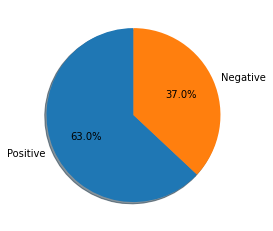

In [9]:
# répartition des classes dans le label
plt.pie(df.sentiment.value_counts(normalize = True), 
        labels=df.sentiment.unique(), 
        autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

Les classes sont légèrement déséquilibrées. 
- actions possibles:
- stratify pendant l'entraînement
- ajout de commentaires négatifs
- SMOTE

Il y a des doublons dans les commentaires 1617 commentaires mais seulement 1534 uniques soit 83 commentaires dupliqués.

In [10]:
duplicated_comments = df.loc[df.comment.duplicated(keep='first')]
duplicated_comments

,comment,sentiment
261,Decor tres agreeable du debut du siecle mais l...,Negative
318,Nous avons passé une soirée d'anniversaire en ...,Negative
330,Nous avons été dîners dans ce fameux restauran...,Negative
349,Le chef Jean Edern est très accessible et prof...,Negative
396,Médiocre et très cher ! 2 salades d'algues au ...,Negative
...,...,...
1559,Après avoir quitté précipitamment le restauran...,Negative
1563,Hors de prix pour une mauvaise expérience Dans...,Negative
1573,Médiocre et très cher ! 2 salades d'algues au ...,Negative
1579,Nous sommes quatre ce jour pour déjeuner en ce...,Negative


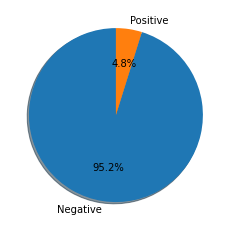

In [11]:
# répartition des classes dans le label parmi les commentaires dupliqués
plt.pie(duplicated_comments.sentiment.value_counts(normalize = True), 
        labels=duplicated_comments.sentiment.unique(), 
        autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

In [54]:
df_clean = df.drop_duplicates()

>95,2% des commentaires dupliqués sont négatifs. Ce qui renforce le déséquilibre.

In [55]:
df_clean.isna().sum() # pas de valeurs manquantes

comment      0
sentiment    0
dtype: int64

## Observation sur les données

- Pas de valeurs manquantes
- Commentaires dupliqués dont 95% négatifs
- Classes du label sentiment légèrement déséquilibrés (63 / 37)

## Chargement du modèle

In [14]:
model = joblib.load("../models/sentiment_pipe.joblib")
model

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(C=1000, gamma=0.001))])

>Pour empêcher les problèmes de compatibilité, on utilisera la version **0.23.2** de Scikit Learn.

In [15]:
import sklearn

sklearn.__version__

'0.23.2'

On a un pipeline Scikit Learn avec 2 étapes : 
- un TF-IDF avec les arguments par défaut du vectorizer
- SVM avec le coefficient C à 1000 et le gamma à 0.001

Ce modèle n'utilise pas les nombreux paramètres du Tf-Idf pour nettoyer les chaînes de caractères (tokenizer, stop_words, token_pattern).

> Action à mener : ajouter une étape de nettoyage des données

En ce qui concerne, les performances du modèle, il faudrait récupérer les métriques de ce dernier et comparer avec un grid search pour savoir s'il s'agit du meilleur modèle SVM. 

On pourra aussi aller plus loin en testant d'autres algorithmes tels que des algorithmes ensemblistes.

In [41]:
# dimension du dataset passé dans le SVM
model.steps[0][1].transform(df.comment.values)

<1617x3466 sparse matrix of type '<class 'numpy.float64'>'
	with 42229 stored elements in Compressed Sparse Row format>

## Performances du modèle sans altération des données ou du modèle

Le dataset **comment_train.csv** a été utilisé au cours de l'entraînement du modèle.

## Création des fonctions de performances

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve, classification_report

In [57]:
def split_data(data):
    # split dataset between features and label
    target = "sentiment"
    X = data.drop(target, axis = 1)
    X = [comment[0] for comment in X.values]
    y = data[target]
    y.loc[y == "Positive"] = 1
    y.loc[y == "Negative"] = 0
    y = y.values.tolist()
    return X, y

In [70]:
# compute metrics without cross validation
def compute_metrics(model, data):
    X, y = split_data(data)
    predictions = model.predict(X)
    
    # define metrics
    print(classification_report(model.predict(X), y))
    
    # plot AUC-ROC curve
    fig, ax = plt.subplots()
    mean_fpr = np.linspace(0, 1, 100)
    viz = plot_roc_curve(model, X, y,
                             name='ROC curve',
                             alpha=0.3, lw=2, ax = ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)

    ax.legend(loc="lower right")
    plt.show()
    
    return None

In [59]:
# evolution : compute metrics with cross validation
def compute_metrics_cv(X, y):
    scores = cross_validate(model, X, y, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1_weighted', 'roc_auc'), return_train_score = True)
    final_scores = {metric : round(np.mean(metric_scores), 3) for metric, metric_scores in scores.items()}
    confidence_intervals = {metric : round(np.std(metric_scores), 2) for metric, metric_scores in scores.items()}
    return (final_scores, confidence_intervals)

## Prédictions sur l'ensemble des données

              precision    recall  f1-score   support

           0       0.26      0.76      0.39       206
           1       0.95      0.69      0.80      1411

    accuracy                           0.70      1617
   macro avg       0.61      0.72      0.59      1617
weighted avg       0.86      0.70      0.75      1617



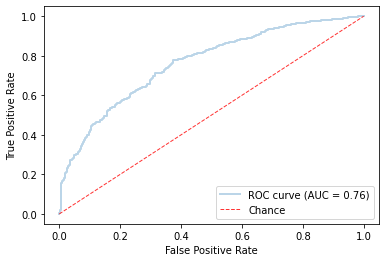

In [71]:
all_data_metrics = compute_metrics(model, df)
all_data_metrics

In [72]:
classification_report(model.predict(X), y, output_dict=True)

{'0': {'precision': 0.2678227360308285,
  'recall': 0.7354497354497355,
  'f1-score': 0.39265536723163846,
  'support': 189},
 '1': {'precision': 0.9507389162561576,
  'recall': 0.7174721189591078,
  'f1-score': 0.8177966101694916,
  'support': 1345},
 'accuracy': 0.7196870925684485,
 'macro avg': {'precision': 0.609280826143493,
  'recall': 0.7264609272044216,
  'f1-score': 0.605225988700565,
  'support': 1534},
 'weighted avg': {'precision': 0.8665986567629456,
  'recall': 0.7196870925684485,
  'f1-score': 0.7654161050096127,
  'support': 1534}}

La précision nous indique que le modèle arrive a détecté 68% des commentaires positifs parmi ceux recensés dans le dataset d'entrainement.  
Le recall nous indique que parmi les commentaires jugés comme positifs, 95% le sont vraiment.  
Le f1 score est une la moyenne harmonique entre la précision et le recall.  
Le modèle est juste dans 70% des cas avec un AUC (taux de séparabilité) de 0.76 

>Les résultats obtenus sont assez moyens.

## Evaluation du modèle avec validation croisée

La fonction **compute_metrics_cv** réalise une cross-validation pour chaque métrique afin d'obtenir des résultats les plus robustes possibles selon la division entre train et test.

In [63]:
X, y = split_data(df_clean)
scores, confidences_intervals = compute_metrics_cv(X, y)
scores

/Users/nohossat/.local/share/virtualenvs/youtube_sentiment_analysis-bsovMP99/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


{'fit_time': 0.473,
 'score_time': 0.187,
 'test_accuracy': 0.865,
 'train_accuracy': 0.999,
 'test_precision': 0.883,
 'train_precision': 0.999,
 'test_recall': 0.918,
 'train_recall': 1.0,
 'test_f1_weighted': 0.864,
 'train_f1_weighted': 0.999,
 'test_roc_auc': 0.939,
 'train_roc_auc': 1.0}

In [64]:
confidences_intervals

{'fit_time': 0.01,
 'score_time': 0.0,
 'test_accuracy': 0.01,
 'train_accuracy': 0.0,
 'test_precision': 0.02,
 'train_precision': 0.0,
 'test_recall': 0.01,
 'train_recall': 0.0,
 'test_f1_weighted': 0.01,
 'train_f1_weighted': 0.0,
 'test_roc_auc': 0.01,
 'train_roc_auc': 0.0}

### Interprétation résultats

Le fit_time est de 0.517 secondes et le score time de 0.198 secondes donc assez rapides.

La précision nous indique que le modèle arrive à détecter 99.9% des commentaires positifs parmi ceux recensés dans le dataset de train mais seulement 89.8% sur le dataset de test.
Le recall nous indique que parmi les commentaires jugés comme positifs, ils le sont tous effectivement sur le dataset de train, ce score tombe à 91% pour les données de test. 

**On observe que ces deux métriques sont assez bonnes donc le léger déséquilibre dans la polarité des commentaires ne semblent pas peser sur la capacité prédictive du modèle.**

Le modèle est juste à 99.9% sur les données de train et à 88% sur les données de test. 
Le taux de séparabilité (AUC) est de 1 pour les données de train : le modèle distingue parfaitement les commentaires positifs des commentaires négatifs. Ce taux tombe à 0.94 sur les données de test.

Au vue des résultats parfaits sur les données de train de la fonction cross_validate, il semblerait ce dataset que le modèle ait été entraîné sur une partie de dataset seulement. Par contre, si cette hypothèse est juste, le modèle aurait surappris les données de train, ce qui est reflété par l'écart substantiel entre les performances du modèle sur les données de train et de test.

> HYPOTHESE : surapprentissage du modèle

## Actions correctrices

### Transform data before saving them into a Mongo DB

In [74]:
df_clean.to_csv("../data/comments.csv", index = False)

### Create a dataset with sentiment values

In [28]:
df1 = pd.read_csv("data/comments_train.csv")
df1.head()

,comment,sentiment
0,J'ai réservé ma table quelques mois à l'avance...,Positive
1,Que dire... Nicolas sale est un chef d excepti...,Positive
2,Dans une rue tranquille non loin du Panthéon u...,Positive
3,Rien à redire le restaurant est irréprochablem...,Positive
4,Comme avec les autres commentaires nos repas é...,Positive


In [45]:
sentiments = pd.DataFrame([{"Sentiment": "Negative", "Value" : 0}, {"Sentiment" : "Positive", "Value" : 1}])
sentiments.to_csv("mongo/sentiments.csv", index = False)